In [1]:
import napari
import os
from tqdm import tqdm
import numpy as np
from ultrack import MainConfig, load_config, track, to_tracks_layer, tracks_to_zarr
import glob2 as glob
import zarr
import skimage.io as io
from skimage.transform import resize
import json

In [2]:
# # set parameters
root = "E:\\Nick\\Cole Trapnell's Lab Dropbox\\Nick Lammers\\Nick\\killi_tracker\\"
project_name = "230425_EXP21_LCP1_D6_1pm_DextranStabWound"
image_zarr = os.path.join(root, "built_data", "zarr_image_files",  project_name + ".zarr")
# label_zarr = os.path.join(root, "built_data", "cleaned_cell_labels", project_name + ".zarr")
ds_factor = 1
config_name = "tracking_jordao_full.txt"
tracking_folder = config_name.replace(".txt", "")
tracking_folder = tracking_folder.replace(".toml", "")

## Load tracks and image data

In [3]:
cfg = load_config(os.path.join(root, "metadata", project_name, config_name))
tracks_df, graph = to_tracks_layer(cfg)

C:\Users\nlammers\miniconda3\envs\ultrack-kf\lib\site-packages\numba\typed\typeddict.py:39: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.
  return d[key]


In [4]:
data_tzyx = zarr.open(image_zarr, mode='r')

In [56]:
from scipy.interpolate import interp1d

# make array to specify wound location
wound_center_array = np.asarray([[315, 457, 424], [315, 427, 424], [315, 405, 410], [315, 372, 434]])
center_frames = np.asarray([0, 59, 84, 118])
frame_vec_full = np.arange(data_tzyx.shape[0])
interpf = interp1d(center_frames, wound_center_array, axis=0)
wound_center_interp = interpf(frame_vec_full)

## Fit sphere for distance estimations

In [7]:
from src.utilities.functions import sphereFit, cart_to_sphere
import pandas as pd
model_name = "LCP-Multiset-v1"
mask_path = os.path.join(root, "built_data", "stitched_labels", model_name, project_name + "_labels_stitched.zarr")
mask_zarr = zarr.open(mask_path, mode="r")

n_points_fit = 10000
ref_frame = 59

mask_array = mask_zarr[0]
z_ref, y_ref, x_ref = np.meshgrid(range(mask_array.shape[0]),
                                              range(mask_array.shape[1]),
                                              range(mask_array.shape[2]),
                                              indexing="ij")

# get location of masked pixels
nc_z = z_ref[mask_array > 0]
nc_y = y_ref[mask_array > 0]
nc_x = x_ref[mask_array > 0]

np.random.seed(364)
sphere_df_list = []
for frame in tqdm(frame_vec_full, "Fitting spheres to lightsheet data..."):
    # get points
    mask_array = mask_zarr[frame]
    # get location of masked pixels
    nc_z = z_ref[mask_array > 0]
    nc_y = y_ref[mask_array > 0]
    nc_x = x_ref[mask_array > 0]
    # choose indices to fit
    fit_indices = np.random.choice(range(len(nc_z)), np.min([n_points_fit, len(nc_z)]), replace=False)
    # fit to sphere
    center_point = np.empty((3, ))
    radius, center_point[2], center_point[1], center_point[0] = sphereFit(nc_x[fit_indices], nc_y[fit_indices], nc_z[fit_indices])
    # store data
    sphere_df = pd.DataFrame(center_point[np.newaxis, :], columns=["Z", "Y", "X"])
    sphere_df["r"] = radius
    sphere_df["t"] = frame
    sphere_df["project"] = project_name
    sphere_df_list.append(sphere_df)



Fitting spheres to lightsheet data...:   1%|          | 1/119 [00:00<01:08,  1.72it/s]C:\Users\nlammers\Projects\killi-tracker\src\utilities\functions.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C, residuals, rank, singval = np.linalg.lstsq(A,f)
Fitting spheres to lightsheet data...:   2%|▏         | 2/119 [00:01<01:41,  1.16it/s]C:\Users\nlammers\Projects\killi-tracker\src\utilities\functions.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C, residuals, rank, singval = np.linalg.lstsq(A,f)
Fitting sphere

AttributeError: 'Rolling' object has no attribute 'head'

In [29]:
sphere_df_master = pd.concat(sphere_df_list, axis=0, ignore_index=True)
# sphere_df_master.loc[8, "t"] = 8
sphere_df_master = sphere_df_master.drop_duplicates(subset=["t", "project"]).loc[:, ["t", "r", "Z", "Y", "X"]]
sphere_df_master_sm = sphere_df_master.copy()
sphere_df_master_sm.loc[:, ["Z", "Y", "X"]] = sphere_df_master_sm.loc[:, ["Z", "Y", "X"]].rolling(10, center=True, min_periods=1).mean()
sphere_df_master_sm.head(10)

,t,r,Z,Y,X
0,0,364.467089,-18.713492,403.891253,406.495922
1,1,364.604133,-19.170352,403.541764,406.380954
2,2,365.968176,-19.468475,403.277494,406.409177
3,3,367.328198,-20.143121,403.033216,406.492003
4,4,366.399553,-20.667846,402.843222,406.556423
5,5,366.115987,-21.057686,402.817310,406.626712
6,6,365.222475,-21.633069,402.702803,406.730672
7,7,367.122448,-22.285454,402.723416,406.658867
8,8,367.122448,-23.113690,402.756760,406.847163
9,9,365.988753,-23.770953,402.618508,406.870297


## Calculate net velocities as a function of time and distance from the stab wound

In [13]:
def find_surface_point(raw_point, center_point, radius):
    # find closest point that is on the sphere
    c_vec = raw_point - center_point
    c_vec = c_vec / np.sqrt(np.sum(c_vec**2))
    r_vec = c_vec * radius
    surf_point = center_point + r_vec

    return surf_point

In [117]:
from tqdm import tqdm 
from astropy.coordinates import cartesian_to_spherical, spherical_to_cartesian

# set meanungful units
tres = 60
scale_vec = np.asarray([1.5, 1.5, 1.5])

time_window = 10 # all calculations will be based on N-frame track fragments 

# loop through time points and get list of distances and signed velocities
master_vel_vec = []

for f in tqdm(frame_vec_full):
    center_point = sphere_df_master_sm.loc[f, ["Z", "Y", "X"]]
    radius = sphere_df_master_sm.loc[f, "r"]
    
    # get wound location
    wound_center_raw = wound_center_interp[f]
    # find closest point that is on the sphere
    wound_center = find_surface_point(wound_center_raw, center_point, radius)

    # add wound center info 
    wc = wound_center - center_point
    w_sph = cartesian_to_spherical(wc[2], wc[1], wc[0])
    w_sph = np.asarray([c.value for c in w_sph])
    sphere_df_master_sm.loc[f, ["wound_z", "wound_y", "wound_x"]] = wound_center[:]
    sphere_df_master_sm.loc[f, ["wound_r", "wound_phi", "wound_theta"]] = w_sph[:]
    
    # find extant tracks
    f_start = f
    f_stop = f + time_window-1
    tracks_filtered = tracks_df.loc[(tracks_df["t"]==f_start) | (tracks_df["t"]==f_stop), :].reset_index(drop=True)
    
    # find tracks that are present for entire window
    tracks_u, tracks_c = np.unique(tracks_filtered["track_id"], return_counts=True)

    tracks_to_use = tracks_u[tracks_c==2]

    vel_vec_temp = []
    for i, id in enumerate(tracks_to_use):
        # get start and end locations
        tracks_temp = tracks_filtered.loc[tracks_filtered["track_id"]==id, :].reset_index(drop=True)
        zyx0_raw = tracks_temp.loc[0, ["z", "y", "x"]].to_numpy()
        zyx1_raw = tracks_temp.loc[1, ["z", "y", "x"]].to_numpy()
        
        # get closest points on sphere surface
        zyx0 = find_surface_point(zyx0_raw, center_point, radius)
        zyx1 = find_surface_point(zyx1_raw, center_point, radius)
        d_cart = zyx1-zyx0
        
        # calculate distance to wound site
        d0 = np.sqrt(np.sum((wound_center-zyx0)**2))#2*radius*np.arcsin(np.sqrt(np.sum((wound_center-zyx0)**2))/(2*radius))
        d1 = np.sqrt(np.sum((wound_center-zyx1)**2))#2*radius*np.arcsin(np.sqrt(np.sum((wound_center-zyx1)**2))/(2*radius))

        # get spherical coordinates
        zyx0_c = zyx0 - center_point
        zyx1_c = zyx1 - center_point
        
        sph0 = cartesian_to_spherical(zyx0_c[2], zyx0_c[1], zyx0_c[0])
        sph0 = np.asarray([c.value for c in sph0])
        sph1 = cartesian_to_spherical(zyx1_c[2], zyx1_c[1], zyx1_c[0])
        sph1 = np.asarray([c.value for c in sph1])
        sph_d = sph1 - sph0
        master_vel_vec.append([f_start, d0, (d1-d0), sph0[0], sph0[1], sph0[2], sph_d[0], sph_d[1], sph_d[2],
                              zyx0[0], zyx0[1], zyx0[2], d_cart[0], d_cart[1], d_cart[2]])


    # master_vel_vec.append(vel_vec_temp)
    

100%|██████████| 119/119 [00:33<00:00,  3.50it/s]


In [118]:
vel_df = pd.DataFrame(master_vel_vec, columns=["frame", "d0", "net_distance", "r0", "phi0", "theta0", "r_d", "phi_d", "theta_d",
                                              "z0", "y0", "x0", "dz", "dy", "dx"])
vel_df.tail(10)

,frame,d0,net_distance,r0,phi0,theta0,r_d,phi_d,theta_d,z0,y0,x0,dz,dy,dx
9937,109,486.248854,-6.456687,390.616641,0.250079,1.340738,-5.684342e-14,0.023281,0.033378,33.118176,763.252499,491.282475,8.784219,0.367214,-12.805062
9938,109,157.672505,-40.758295,390.616641,1.205125,1.562898,0.000000e+00,0.107501,-0.003289,301.238872,534.429219,406.082374,12.880560,-39.948189,0.012511
9939,109,100.926492,12.354618,390.616641,1.265291,0.208188,0.000000e+00,-0.030334,0.036683,308.977454,419.041489,519.930147,-3.734650,6.925398,9.941010
9940,109,113.888683,-17.657486,390.616641,1.210889,5.993480,0.000000e+00,0.043517,-0.123179,302.037902,355.458441,536.816749,5.638647,-9.466876,-20.514729
9941,109,48.755154,11.895865,390.616641,1.416013,4.814500,0.000000e+00,-0.034973,0.022944,322.395126,334.852140,411.117618,-2.341611,-13.196305,3.051358
9942,109,72.616617,4.841385,390.616641,1.314369,5.700296,5.684342e-14,-0.005734,-0.352975,314.292665,340.225862,487.690916,-0.574236,-26.973568,-22.666694
9943,109,408.547729,9.712332,390.616641,0.537324,2.893864,0.000000e+00,-0.029898,0.027459,136.380948,477.041243,79.651970,-10.120816,-7.689907,-7.822439
9944,109,484.266581,-1.071465,390.616641,0.175743,0.045340,1.136868e-13,0.004951,0.035341,4.743717,412.189825,789.183876,1.903324,13.536772,-1.197556
9945,109,50.985954,29.465595,390.616641,1.369902,5.709104,0.000000e+00,-0.075463,0.095355,319.209071,352.428616,470.429692,-6.965789,-6.766869,29.148863
9946,109,23.663060,-11.198067,390.616641,1.442649,5.919437,-5.684342e-14,0.030770,0.014388,323.862017,376.997766,451.632688,1.352420,4.761000,-10.970509


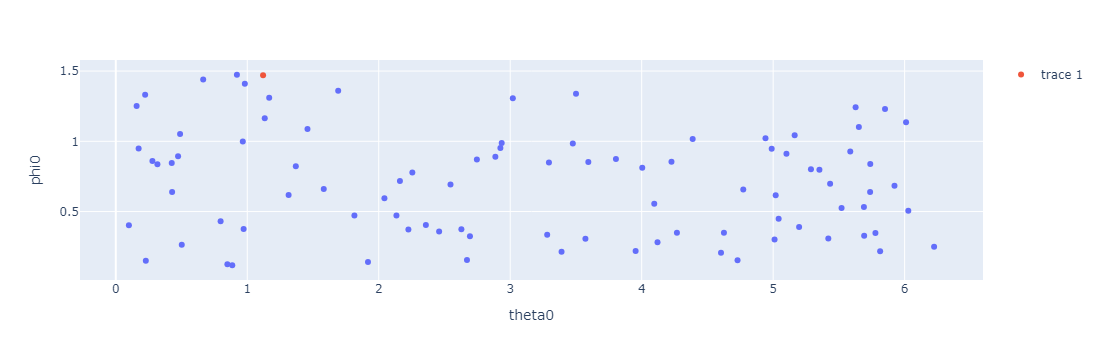

In [66]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from matplotlib import pyplot as plt

frame=50
fig = px.scatter(vel_df.loc[vel_df["frame"]==frame], x="theta0", y="phi0")
fig.add_trace(go.Scatter(x=[wound_center_interp[frame, 2]], 
                         y=[sphere_df_master_sm.loc[frame, "wound_phi"]], mode="markers"))
fig.show()


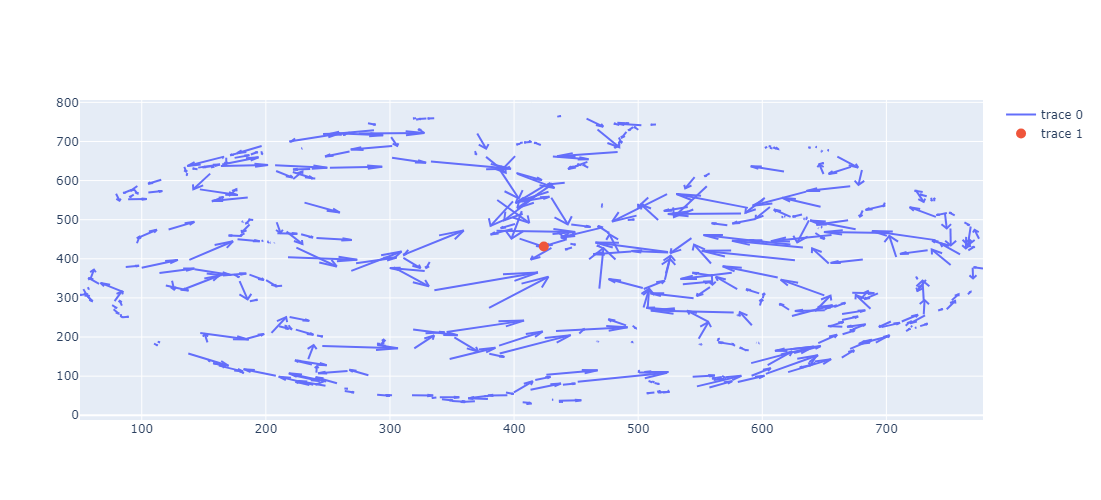

In [78]:
import plotly.figure_factory as ff

frames=np.asarray([10, 20, 30, 40, 50])
ft = np.isin(vel_df["frame"],frames)
fig = ff.create_quiver(x=vel_df.loc[ft, "x0"], y=vel_df.loc[ft, "y0"], u=vel_df.loc[ft, "dx"], v=vel_df.loc[ft, "dy"],
                      marker_size=12, scale=1)

fig.add_trace(go.Scatter(x=[wound_center_interp[frame, 2]], 
                         y=[wound_center_interp[frame, 1]], mode="markers", marker=dict(size=10)))

fig.update_layout(
    autosize=False,
    width=500,
    height=500)

fig.show()

## Do the great circle distances make sense?

In [119]:
for f in frame_vec_full:
    vel_df.loc[vel_df["frame"]==f,["wound_z", "wound_y", "wound_x"]] = np.tile(wound_center_interp[f, :], (np.sum(vel_df["frame"].to_numpy()==f), 1))

vel_df["x_rel"] = vel_df["x0"] - vel_df["wound_x"]
vel_df["y_rel"] = vel_df["y0"] - vel_df["wound_y"]
vel_df["t_polar"] = np.arctan2(vel_df["y_rel"], vel_df["x_rel"])
vel_df["x_polar"] = np.multiply(vel_df["d0"], np.cos(vel_df["t_polar"]))
vel_df["y_polar"] = np.multiply(vel_df["d0"], np.sin(vel_df["t_polar"]))
vel_df["u_polar"] = np.divide(np.multiply(vel_df["net_distance"], vel_df["x_polar"]), vel_df["d0"])
vel_df["v_polar"] = np.divide(np.multiply(vel_df["net_distance"], vel_df["y_polar"]), vel_df["d0"])

In [132]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

frames=np.asarray([10, 15, 20])

ft = np.isin(vel_df["frame"],frames)

x=vel_df.loc[ft, "x_polar"]
y=vel_df.loc[ft, "y_polar"] 
u=vel_df.loc[ft, "u_polar"]
v=vel_df.loc[ft, "v_polar"]


colors = vel_df["net_distance"].to_numpy()
clip_val = np.min([np.abs(np.max(colors)), np.abs(np.min(colors))])
colors = np.clip(colors,-clip_val, clip_val)
ft = colors < 0
colors = colors - np.min(colors)
colors = colors / np.max(colors)
# norm = Normalize()
# norm.autoscale(colors)
# we need to normalize our colors array to match it colormap domain
# which is [0, 1]

colormap = cm.RdYlBu


# pick your colormap here, refer to 
# http://matplotlib.org/examples/color/colormaps_reference.html
# and
# http://matplotlib.org/users/colormaps.html
# for details
plt.figure(figsize=(6, 6))
# plt.xlim(-2, 2)
# plt.ylim(-2, 2)
plt.quiver(x[ft], y[ft], u[ft], v[ft], color=colormap(colors[ft]), scale=1, angles='xy',scale_units='xy')
           #scale_units='xy', scale=1, pivot='mid')

plt.show()

IndexError: Boolean index has wrong length: 9947 instead of 303

<Figure size 600x600 with 0 Axes>

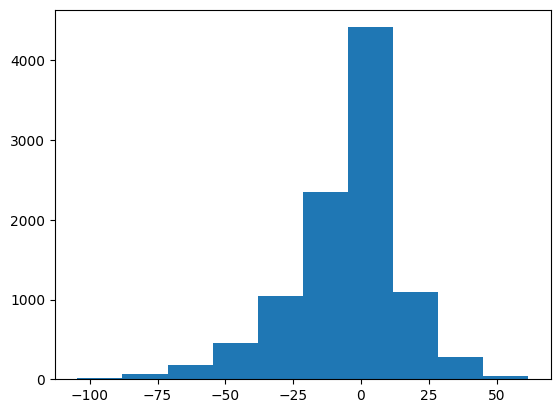

In [121]:
plt.hist(vel_df["net_distance"])
plt.show()

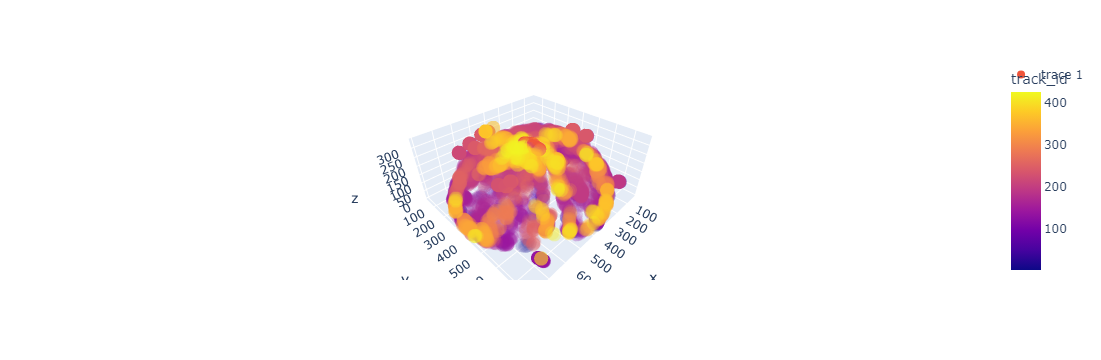

In [60]:
fig = px.scatter_3d(tracks_df, x="x", y="y", z="z", color="track_id", opacity=0.1)
fig.add_trace(go.Scatter3d(x=wound_center_interp[:, 2], y=wound_center_interp[:, 1], z=wound_center_interp[:, 0], mode="markers"))
fig.show()

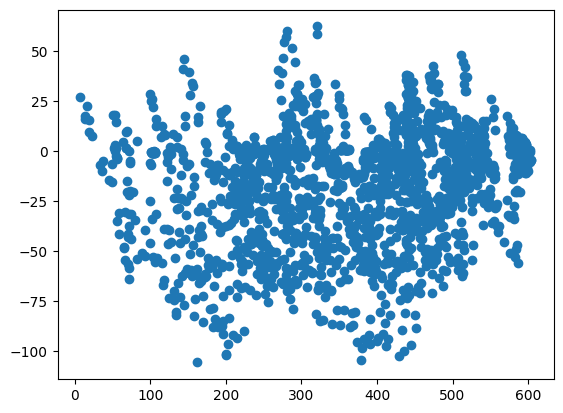

In [61]:

vel_array = np.asarray(master_vel_vec)
plot_filter = (vel_array[:, 0] >= 10) & (vel_array[:, 0] <= 30)

plt.scatter(x=vel_array[plot_filter, 1], y=vel_array[plot_filter, 2])
plt.show()